In [1]:
from keras import backend as K
import numpy as np
from keras.datasets import mnist
from keras.layers import MaxPooling2D
import math
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras import applications
import skimage

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 16s 260us/step - loss: 6.6243 - acc: 0.5735 - val_loss: 0.1105 - val_acc: 0.9662
Epoch 2/3
60000/60000 [==============================] - 10s 167us/step - loss: 0.0861 - acc: 0.9748 - val_loss: 0.0627 - val_acc: 0.9792
Epoch 3/3
60000/60000 [==============================] - 10s 173us/step - loss: 0.0611 - acc: 0.9821 - val_loss: 0.0496 - val_acc: 0.9846


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

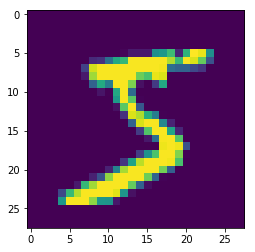

In [2]:

#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


#plot the first image in the dataset
plt.imshow(X_train[0])

X_train[0].shape

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)


#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]


#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1), name='conv1'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

model.predict(X_test[:4])
y_test[:4]

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
Total params: 27,114
Trainable params: 27,114
Non-trainable params: 0
_________________________________________________________________


In [4]:
input_img = model.input  # Placeholder

In [5]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])  # Help us index different layers in the following steps.

In [6]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [7]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    return x

In [21]:
a = model.get_weights()
firstlayer = []
for i in range(64):
    firstlayer.append(a[0][:,:,0,i])


In [42]:
# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
idx = 1
for Filter in firstlayer:
    l1f1_in_tmp = []
    for row in Filter:
        row_tmp = []
        for entry in row:
            if entry >=0:
                row_tmp.append(1)
            else:
                row_tmp.append(0)
        l1f1_in_tmp.append(row_tmp)
    idx = idx+1

    kept_filters.append((l1f1_in_tmp, idx))
    #end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

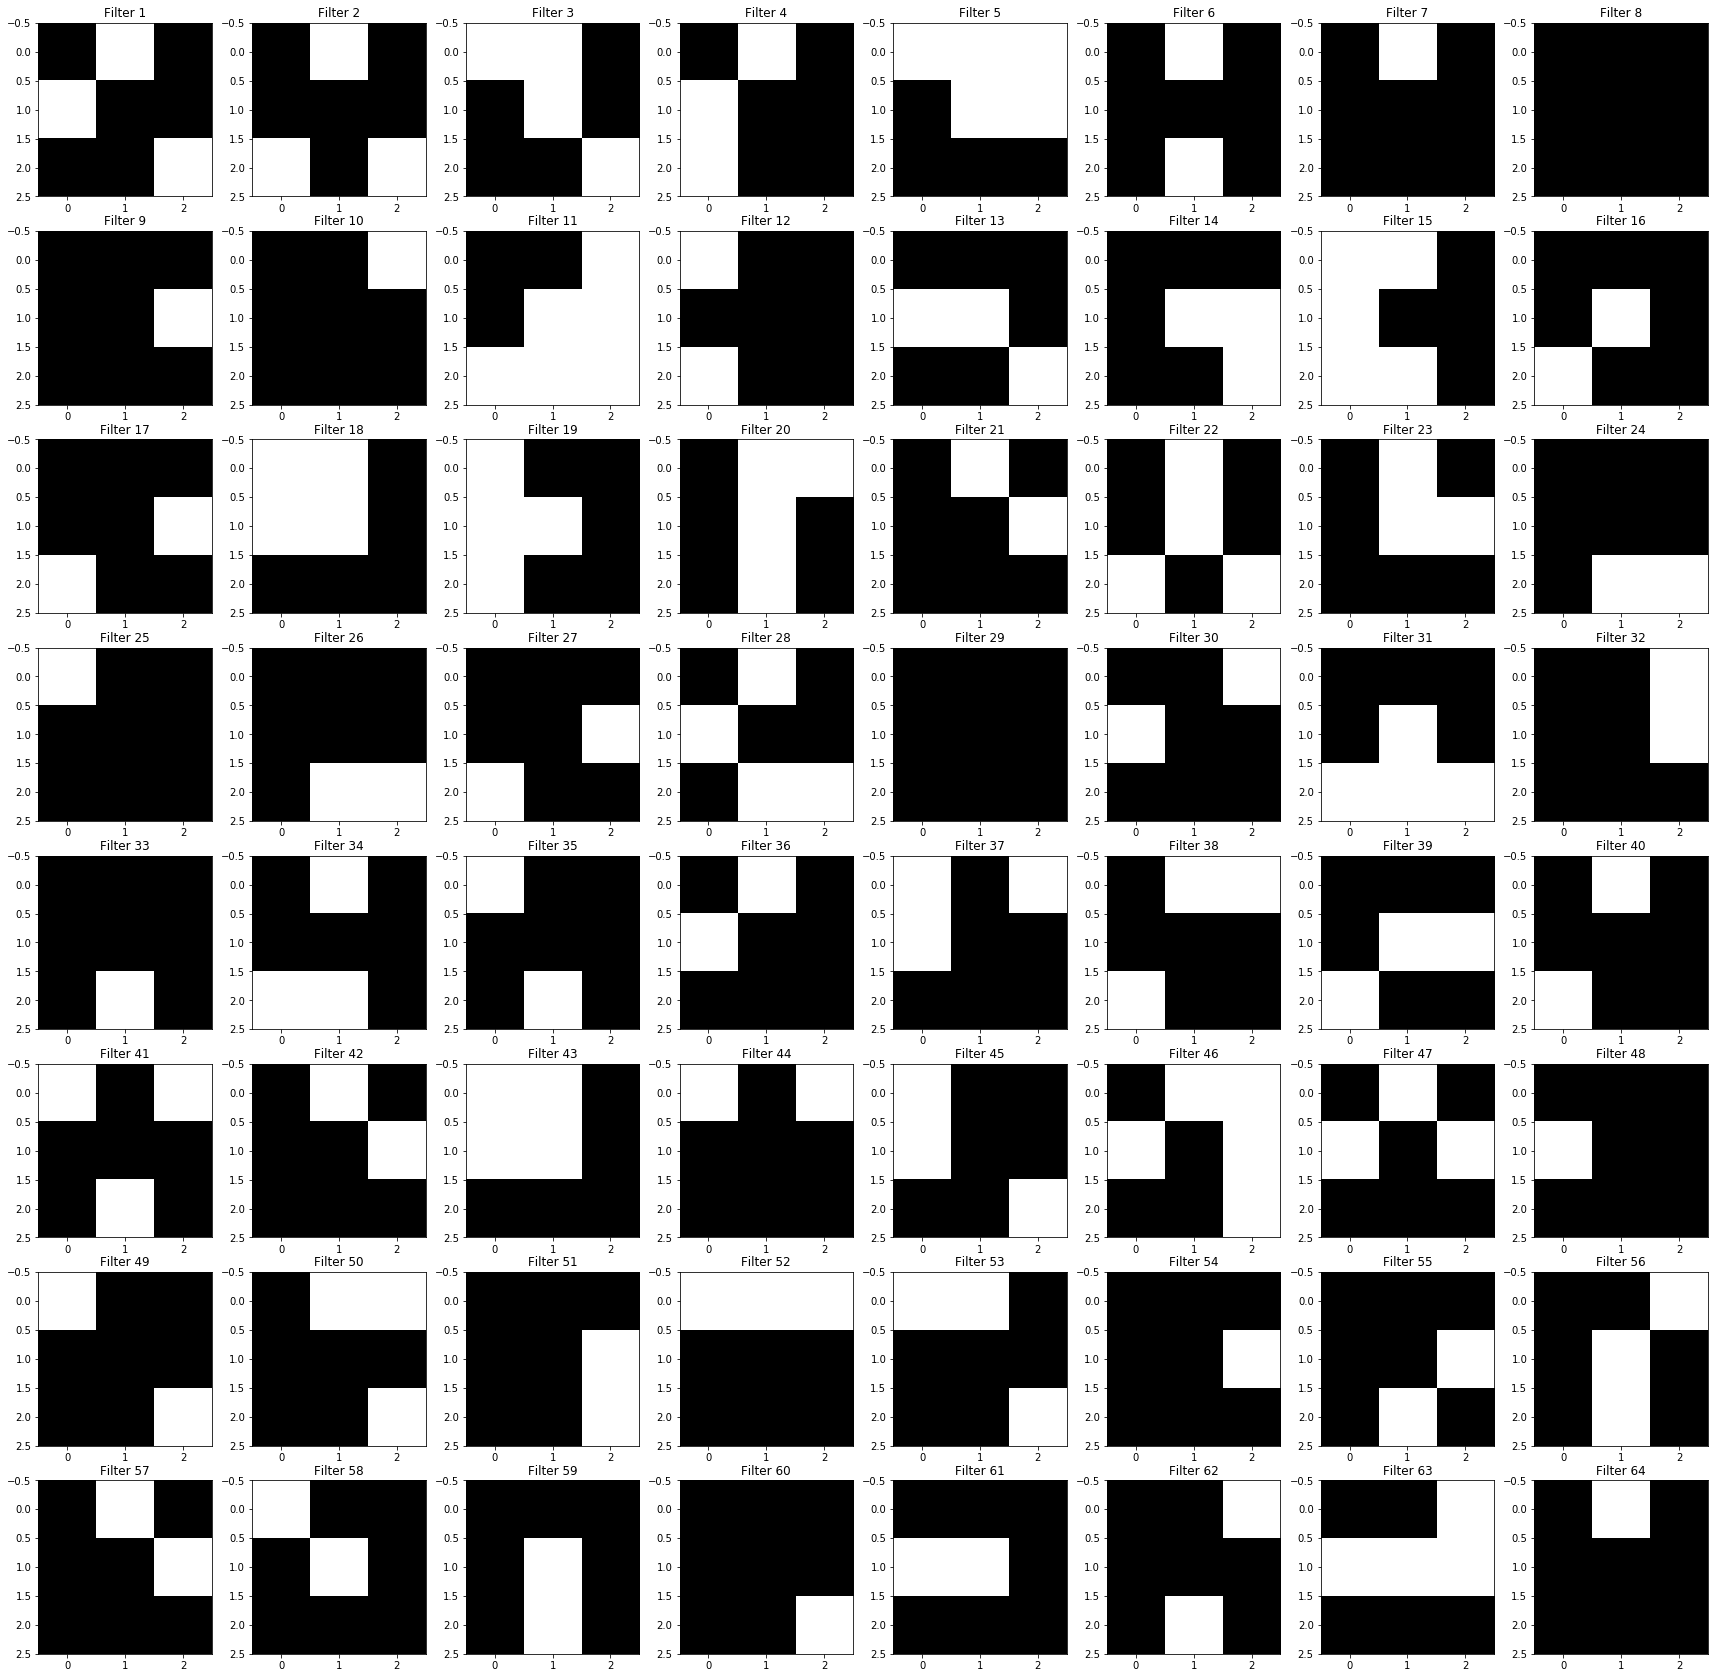

In [50]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0],cmap='gray')

In [30]:

# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
for filter_index in range(64):
    # we only scan through the first 10 filters,
    # but there are actually 64 of them
    #print('Processing filter %d' % filter_index)
    #start_time = time.time()
    
    layer_output = layer_dict['conv1'].output
    loss = K.sum(layer_output[:, :, :, filter_index])  #We had a hard time to realize tha idea, "maximize activation". 
    # It was the artical "How convolutional neural networks see the world" inspired us. 
    # And the method is from the article.
    
    # The gradient of the loss with respect to input image.
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads, when the input picture is given
    iterate = K.function([input_img], [loss, grads])  # This beckend function is also from the article 
    # "How convolutional neural network see the world"
    

    # step size for gradient ascent
    step = 0.2

    # we start from a image with some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        #for row in input_img_data:
        #    for item in row:
        #        factor = np.random.uniform(-1,1)
        #        item = item + factor * 0.1

        #print(type(loss_value))
        #print(type(input_img_data))

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
     # decode the resulting input image
    
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    #end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

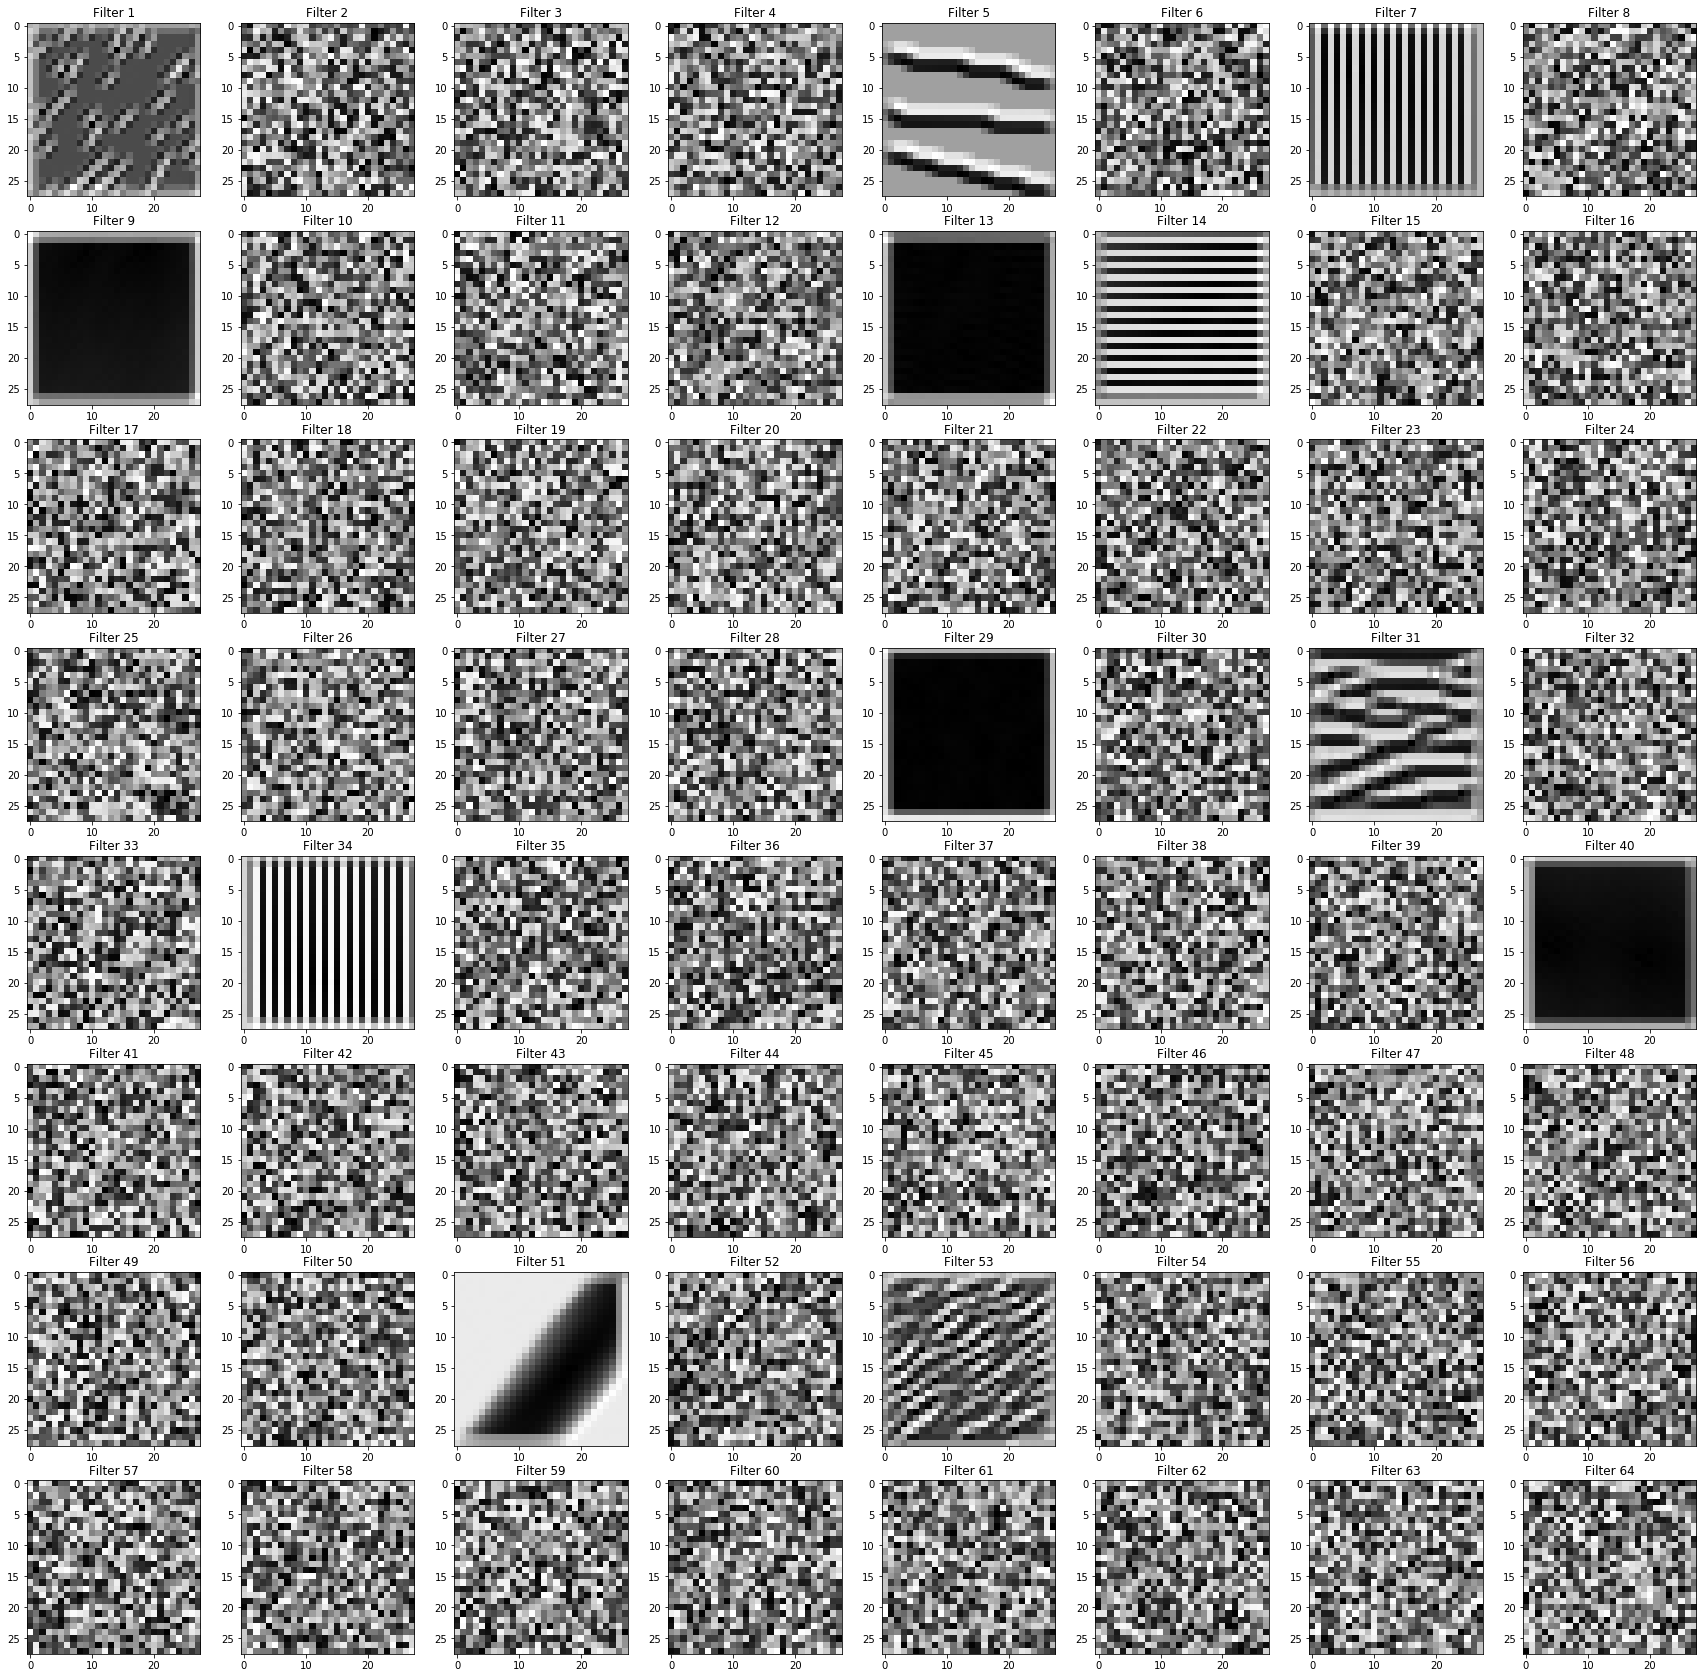

In [31]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0][:,:,0].reshape(28,28),cmap='gray')

In [40]:
# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
for filter_index in range(64):
    # we only scan through the first 10 filters,
    # but there are actually 64 of them
    #print('Processing filter %d' % filter_index)
    #start_time = time.time()
    
    layer_output = layer_dict['conv1'].output
    loss = K.sum(layer_output[:, :, :, filter_index])  #We had a hard time to realize tha idea, "maximize activation". 
    # It was the artical "How convolutional neural networks see the world" inspired us. 
    # And the method is from the article.
    
    # The gradient of the loss with respect to input image.
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads, when the input picture is given
    iterate = K.function([input_img], [loss, grads])  # This beckend function is also from the article 
    # "How convolutional neural network see the world"
    

    # step size for gradient ascent
    step = 0.25

    # we start from a image with some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])

        
        input_img_data += grads_value * step
        
        input_img_data = input_img_data.reshape(28,28)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.05)
        input_img_data = skimage.transform.rescale(input_img_data,1.01)
        input_img_data = skimage.transform.resize(input_img_data,(28,28))
        input_img_data = input_img_data.reshape(1,28,28,1)
        
        #input_img_data = 
        #print(type(loss_value))
        #print(type(input_img_data))

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
     # decode the resulting input image
    
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    #end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

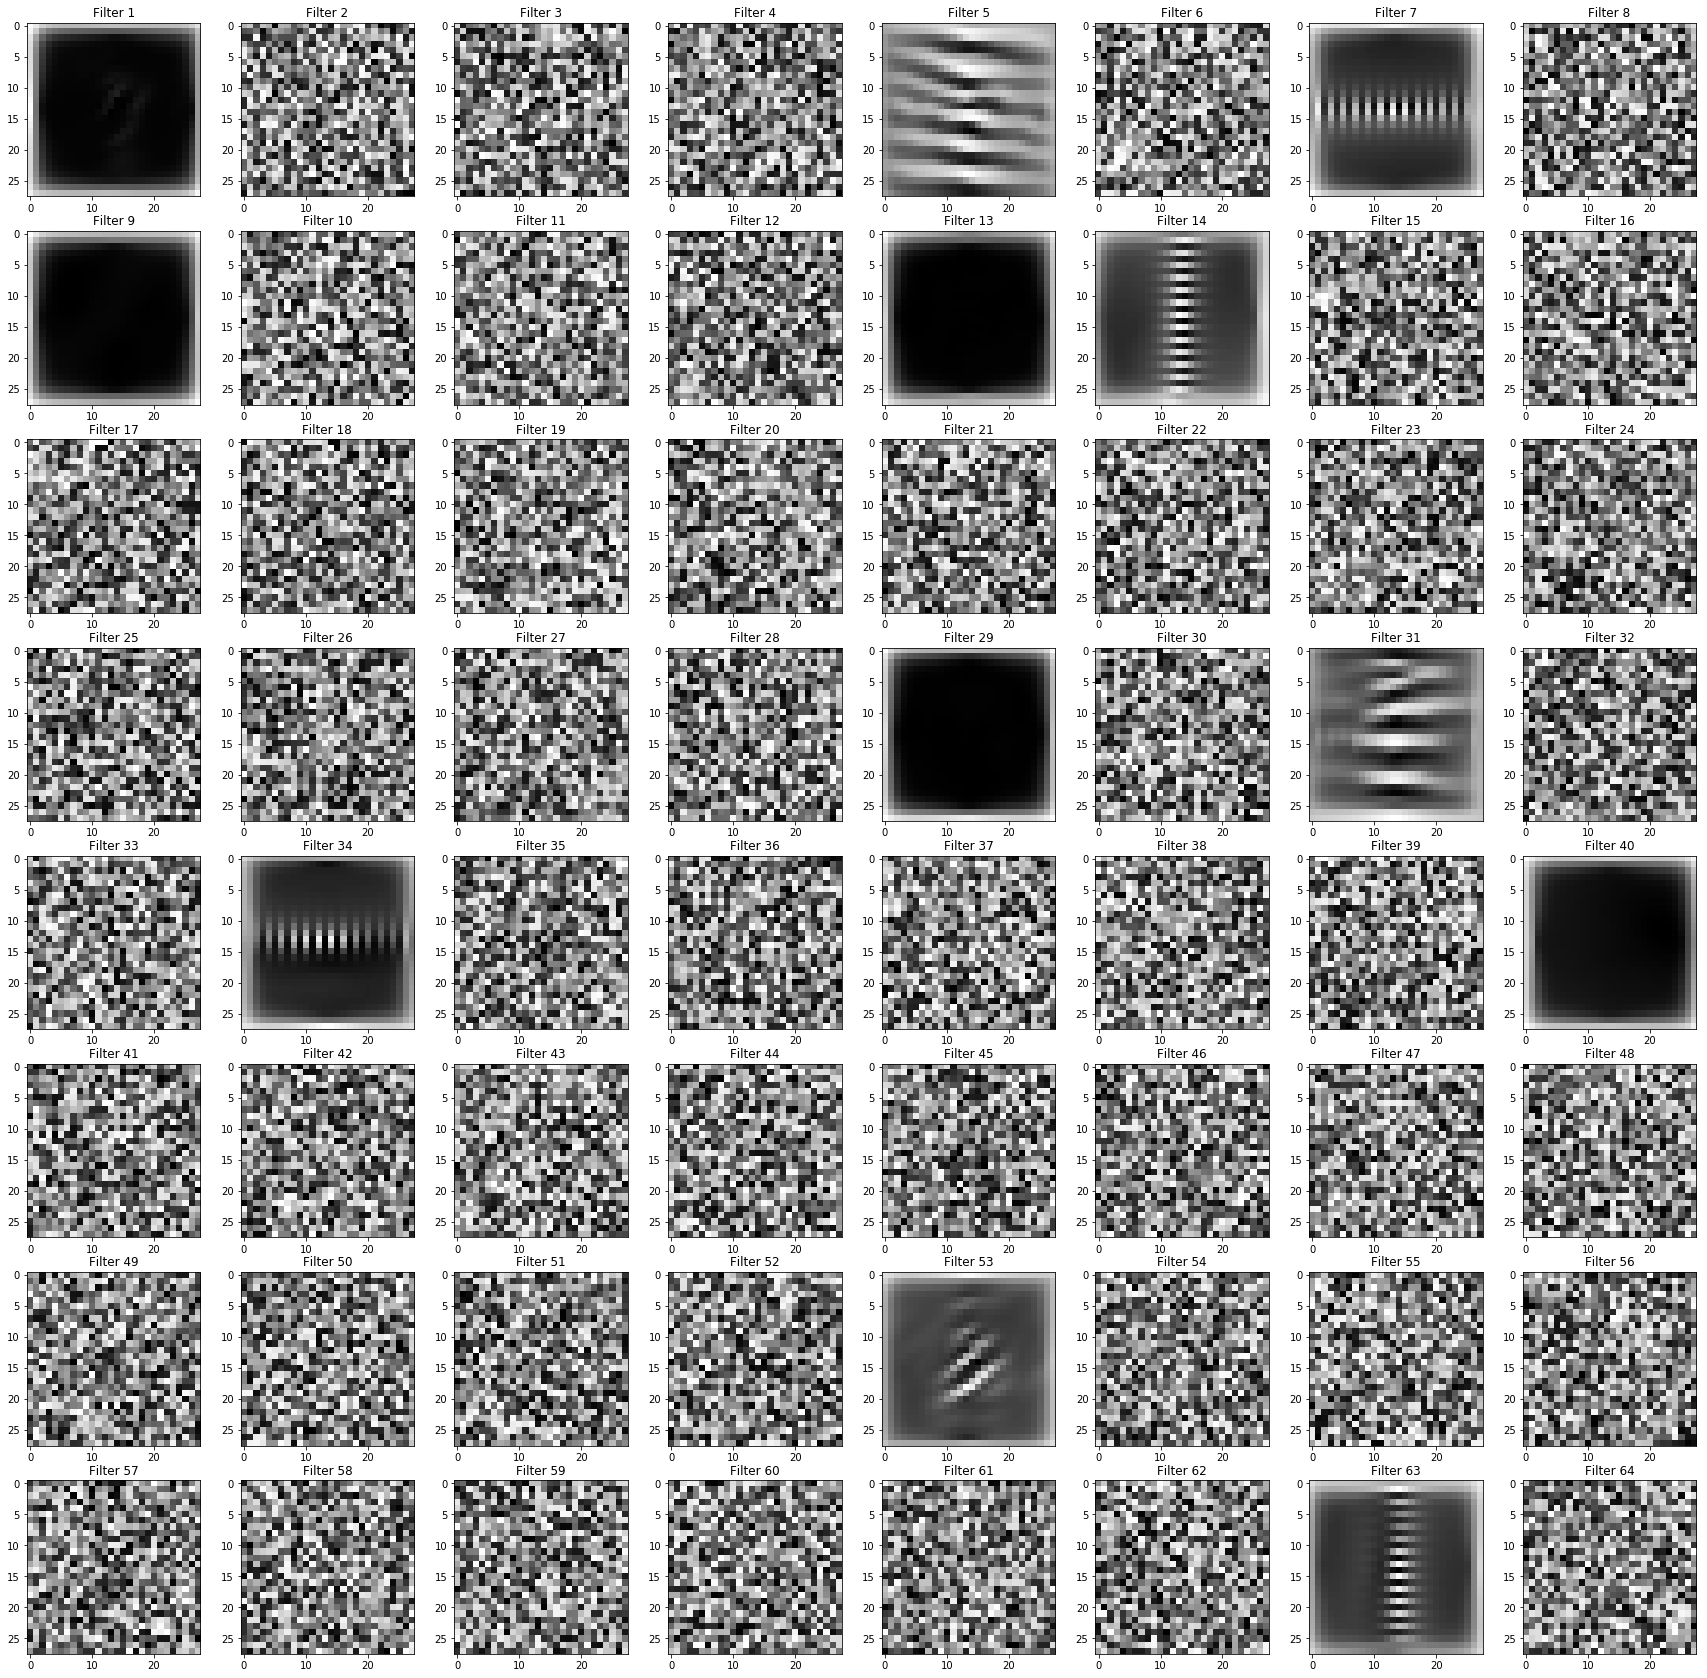

In [41]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0][:,:,0].reshape(28,28),cmap='gray')

In [51]:
secondlayer = []
for i in range(32):
    secondlayer.append(a[2][:,:,0,i])

In [52]:
# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
idx = 1
for Filter in secondlayer:
    l1f1_in_tmp = []
    for row in Filter:
        row_tmp = []
        for entry in row:
            if entry >=0:
                row_tmp.append(1)
            else:
                row_tmp.append(0)
        l1f1_in_tmp.append(row_tmp)
    idx = idx+1

    kept_filters.append((l1f1_in_tmp, idx))
    #end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

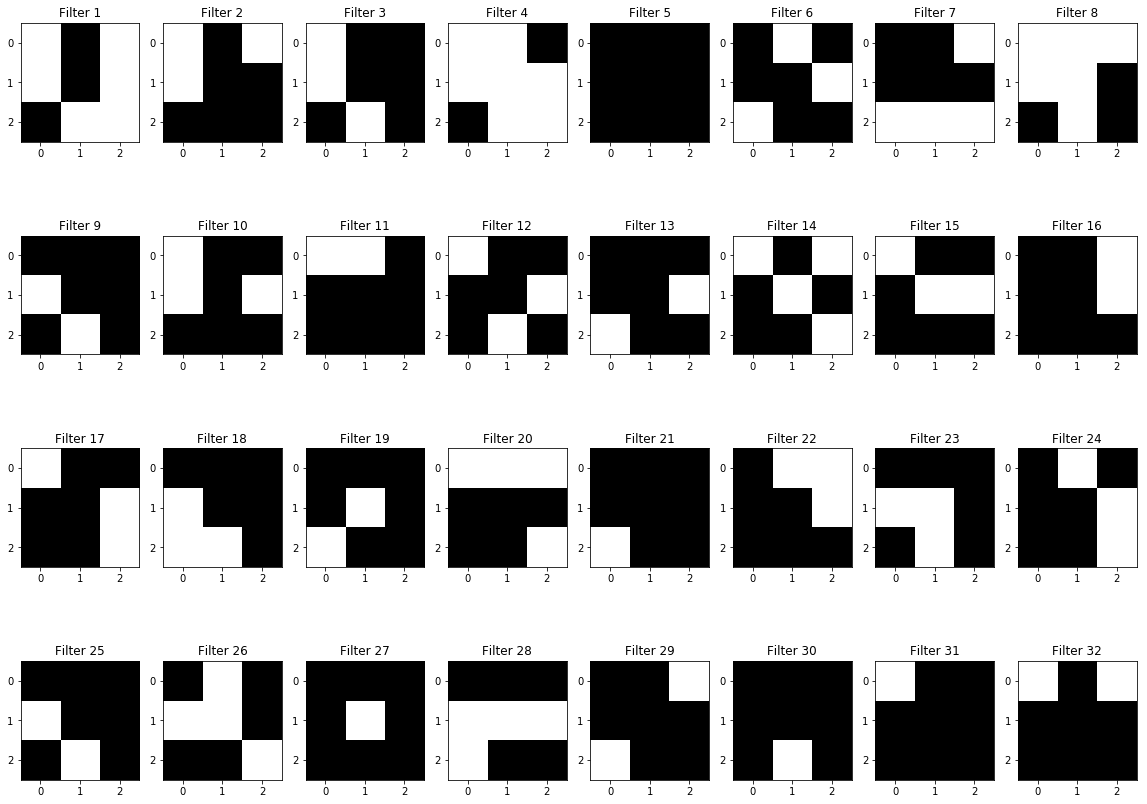

In [53]:
# Show the 64 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0],cmap='gray')

In [28]:
# Find an input image that maximaly activate the 64 filters in conv2.
kept_filters_2 = []
for filter_index in range(32):
    # we only scan through the first 10 filters,
    # but there are actually 64 of them
    #print('Processing filter %d' % filter_index)
    #start_time = time.time()
    
    layer_output = layer_dict['conv2'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    

    # step size for gradient ascent
    step = 0.2

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        #print(type(loss_value))
        #print(type(input_img_data))

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
     # decode the resulting input image
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))
    #end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

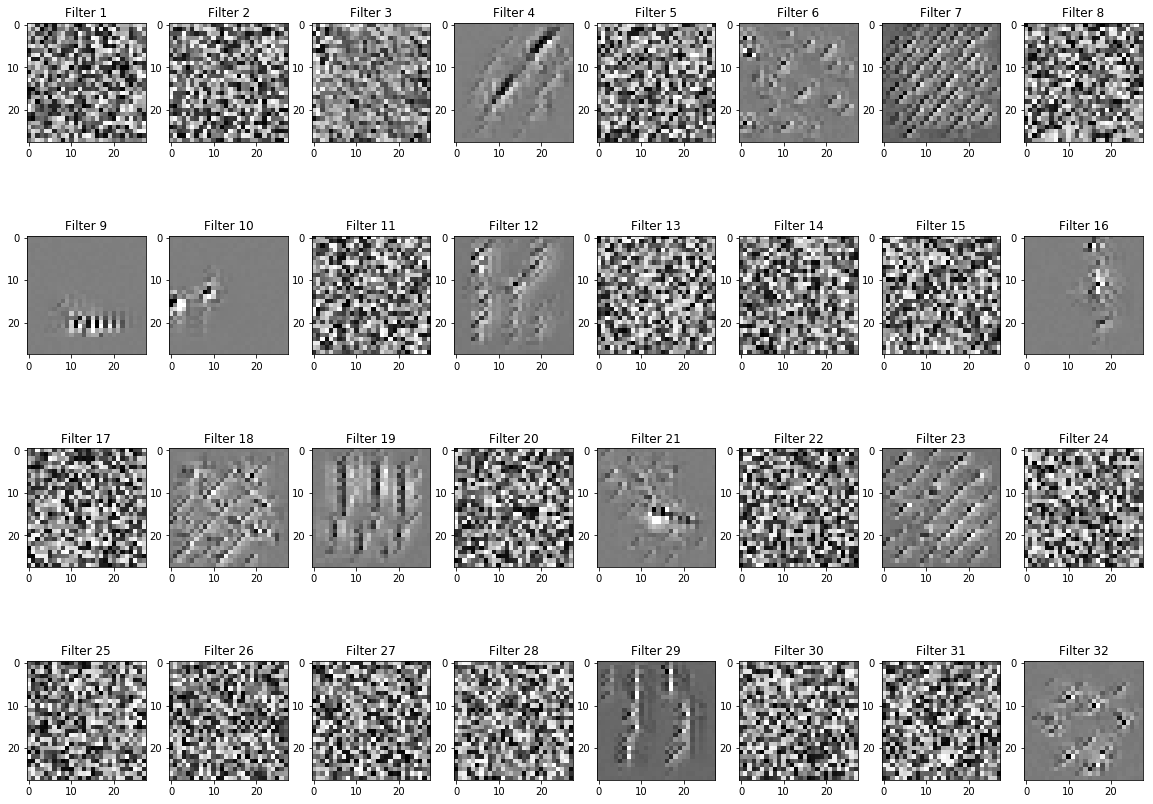

In [29]:
# Show the 64 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(28,28),cmap='gray')

In [36]:
# Find an input image that maximaly activate the 64 filters in conv2.
kept_filters_2 = []
for filter_index in range(32):
    # we only scan through the first 10 filters,
    # but there are actually 64 of them
    #print('Processing filter %d' % filter_index)
    #start_time = time.time()
    
    layer_output = layer_dict['conv2'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    

    # step size for gradient ascent
    step = 0.2

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        input_img_data = input_img_data.reshape(28,28)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01)
        input_img_data = skimage.transform.resize(input_img_data,(28,28))
        input_img_data = input_img_data.reshape(1,28,28,1)
        #print(type(loss_value))
        #print(type(input_img_data))

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
     # decode the resulting input image
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))
    #end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

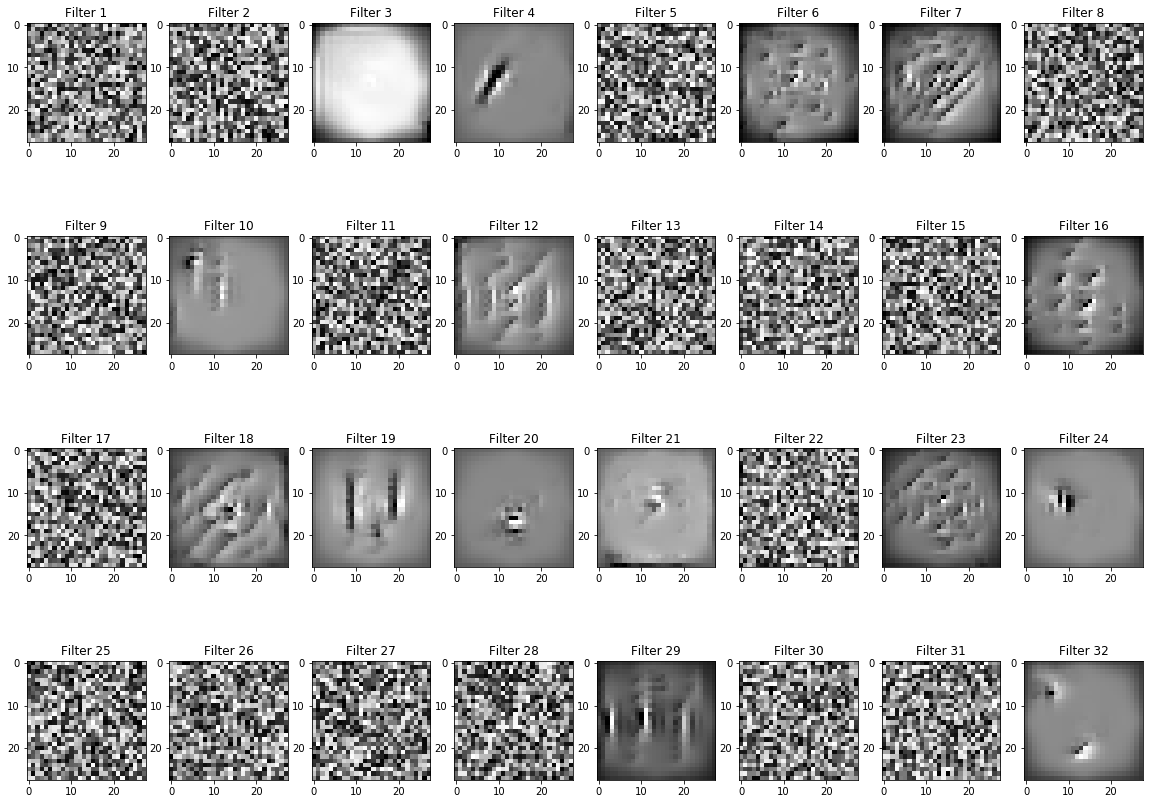

In [37]:
# Show the 64 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(28,28),cmap='gray')

In [ ]:
import os
os.getcwd()

In [22]:
    input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128